In [1]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Circle, Rectangle, Arc
from plotting_helper import draw_court

import seaborn as sns
import scipy.interpolate

import numpy as np
from sklearn.decomposition import NMF
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline

# Shot Profiles

Each NBA player has a different offensive playstyle that can be reflected in some degree by the frequency of shots that they take.  How do we understand this difference and how can we use it to reflect how similar any two players may be?

One approach is to assume that there are really only a few different shot profiles in the NBA.  For example, if someone is exclusively a three point shooter, than their shot frequency inside the three point line will be nearly zero.  However, in reality, each player is a unknown mix of the different profiles in different proportions.

One way that this can be done is using Non-negative Matrix Factorization (NMF), which decomposes a matrix into $A$ into a low-rank set of components (which we will call shot profiles) and a set of loadings/weights for each player.  Mathematically, let $N$ be the number of players in our dataset and let $M$ be the number of possible court positions. Let $A \in \mathbb{R}^{N x M}$ be the shot matrix where $A_{i,j}$ is the number of total shots player $i$ took in court position $j$.  Then NMF tries to solve:

$$
\begin{align}
    A \approx WH
\end{align}
$$
where $W \in \mathbb{R}^{N x R}$ and $H \in \mathbb{R}^{R x M}$, with $R << M$.  Each row in $H$ represents a specific shot profile and each row in $W$ represents how much that player linearly corresponds to each shot profile.

We apply this methodology to the 2019-20 NBA roster, keeping in mind that this is an ongoing season and has the fewest total shots.

## Helper functions

We first process the data into the form of matrix $A$.  Below are some helper functions to help visualize the court and the discretization we will use.

In this dataset, each shot is given an x-y coordinate corresponding to the half-court location that it was taken.  The coordinate represents the number of feet in reference to the hoop, which is fixed at $(0,0)$.  The left and right boundaries are thus located at $x = -25$ and $x = 25$ respectively while the baseline is located at $y = -4.75$.

As these coordinates are continuous, we instead discretize the court into bins of $1 \times 1$, counting all shots taken in that particular area as coming from the same position.  This results to a $50 \times 47$ bins.  This binning strategy generally makes sense as a player generally occupies an area this large anyways.

In [2]:
shot_x_range = [-25., 25.]
shot_y_range = [-4.75, -4.75 + 47]
player_index = pd.read_csv("players_index.csv")
rosters = pd.read_csv("roster.csv")

In [3]:
def inv_logit(x):
    return 1/(1 + np.exp(-x))

def map_range(ra, rb, v):
    return rb[0] + ((v - ra[0]) * (rb[1] - rb[0]))/(ra[1] - ra[0])

def discretize_space(range_x, range_y, nx, ny):
    return np.meshgrid(np.arange(range_x[0], range_x[1], (range_x[1] - range_x[0])/nx),
                       np.arange(range_y[0], range_y[1], (range_y[1] - range_y[0])/ny))

def create_bins(shots, range_x, range_y, nx, ny, normed = False):
    
    # Create coordinates of the court.  Each position is centered on the square.
    coords = discretize_space(range_x, range_y, nx, ny)
    coords[1] = np.flip(coords[1])
    
    # Bin all of the shots in the same cell together
    bins = np.zeros((ny,nx))
    made_shots = np.zeros((ny, nx))
    ilx = (range_x[1] - range_x[0])/nx
    ily = (range_y[1] - range_y[0])/ny
    coords[0] = coords[0] + ilx/2
    coords[1] = coords[1] + ily/2
    for i in range(shots.shape[0]):
        idx_x = int((shots[i,0] - range_x[0])//ilx)
        idx_y = int((shots[i,1] - range_y[0])//ily)

        bins[min(idx_y,ny - 1),min(idx_x,nx - 1)] += 1
        if shots[i,2] == 1:
            made_shots[min(idx_y,ny - 1),min(idx_x,nx - 1)] += 1
    bins = np.flip(bins)
    made_shots = np.flip(made_shots)
    if normed:
        bins = bins/shots.shape[0]
    return coords, bins, made_shots

def make_adjacency_matrix(nx, ny):
    M = np.zeros((nx*ny, nx * ny))
    for r in range(nx):
        for c in range(ny):
            i = r * ny + c
            if c > 0:
                M[i-1, i] = M[i, i - 1] = 1
            if r > 0:
                M[i - ny, i] = M[i, i - ny] = 1
    return M

def visualize_gridding(nx, ny):
    fig, ax = plt.subplots()
    ax.set_xlim(shot_x_range[0],shot_x_range[1])
    ax.set_ylim(shot_y_range[0],shot_y_range[1])
    ax.set_title(team)
    
    ilx = (shot_x_range[1] - shot_x_range[0])/nx
    ily = (shot_y_range[1] - shot_y_range[0])/ny
    for j in range(nx):
        ax.axvline(ilx * (j + 1) + shot_x_range[0])
    for j in range(ny):
        ax.axhline(ily * (j + 1) + shot_y_range[0])

    ax.set_aspect(47/50)
    fig.set_size_inches(10,10)
    
def is_two(x, y):
    if y < -4.75 + 14:
        if np.abs(x) < 22.0:
            return True
    else:
        if np.linalg.norm([x, y]) < 23.75:
            return True
    return False

def get_shot_values(nx, ny):
    # Create coordinates of the court.  Each position is centered on the square.
    coords = discretize_space(shot_x_range, shot_y_range, nx, ny)
    coords[1] = np.flip(coords[1])
    
    # Bin all of the shots in the same cell together
    bins = np.zeros((ny,nx))
    made_shots = np.zeros((ny, nx))
    ilx = (shot_x_range[1] - shot_x_range[0])/nx
    ily = (shot_y_range[1] - shot_y_range[0])/ny
    coords[0] = coords[0] + ilx/2
    coords[1] = coords[1] + ily/2
    pt_values = np.zeros((ny,nx))
    for i in range(ny):
        for j in range(nx):
            if is_two(coords[0][i,j], coords[1][i,j]):
                pt_values[i,j] = 2
            else:
                pt_values[i,j] = 3
    return pt_values

## Processing the Data

Using the helper functions above, we read in the data.  To account for players that have almost 0 activity, we set the minimum total number of shots at 25.  We also normalize the number of shots for each player so that instead of raw shot count, it is the proportion of total shots taken at each position.

In [4]:
# Read in data for each player
player_names = []
player_name_map = {}
player_dfs = []
for i, row in player_index.iterrows():
    try:
        pn = row['PLAYER_NAME']
        df = pd.read_csv("players_data/%s/2018-19_shots.csv" % row['PLAYER_ID'])
        if df.shape[0] > 25:
            df["LOC_X"] = df["LOC_X"]/10
            df["LOC_Y"] = df["LOC_Y"]/10
            player_dfs.append(df)
            c = len(player_names)
            player_name_map[pn] = c
            player_names.append(pn)
    except:
        pass

In [5]:
# Create discretized bins
nx, ny = 50, 47
bins = []
for i in range(len(player_dfs)):
    coords, total_shots, shots_made = create_bins(player_dfs[i][["LOC_X","LOC_Y","SHOT_MADE_FLAG"]].values, shot_x_range, shot_y_range, nx, ny, normed = True)
    am = make_adjacency_matrix(nx, ny)
    bins.append((coords, total_shots, shots_made, am))
total_shot_matrix = np.asarray([b[1].flatten() for b in bins])

As an example of the data, lets visualize a few key players

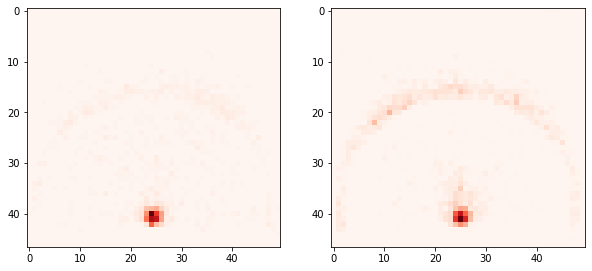

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(total_shot_matrix[player_name_map["LeBron James"]].reshape(47,50), cmap = 'Reds')
ax[1].imshow(total_shot_matrix[player_name_map["James Harden"]].reshape(47,50), cmap = 'Reds')
fig.set_size_inches(10,10)

## Characterizing Offensive Shot Profiles

With all of the data read into the total shot matrix, we now can run NMF.  We run 4 components as these seem to give the best interpretability of components in terms of what we believe.

In [9]:
n_components = 4
model = NMF(n_components=n_components, init = 'random', beta_loss = 'kullback-leibler', solver = 'mu', max_iter = 10000)
W = model.fit_transform(total_shot_matrix)
H = model.components_

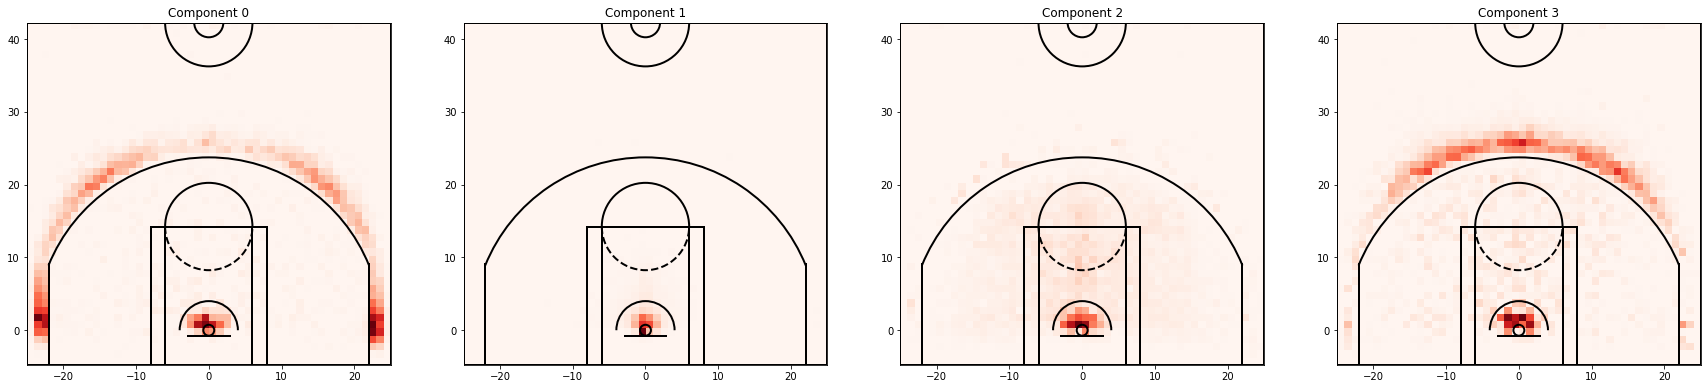

In [10]:
fig, ax = plt.subplots(1,n_components)
for i in range(n_components):
    ax[i] = draw_court(ax = ax[i], outer_lines = True)
    ax[i].set_xlim([-25,25])
    ax[i].set_ylim([-4.75,-4.75 + 47])
    ax[i].set_aspect(47/50)
    ax[i].imshow(H[i,:].reshape(47,50), extent = (-25,25,-4.75,-4.75 + 47), cmap = 'Reds')
    ax[i].set_title("Component %d" % i)
fig.set_size_inches(30, 12)

These components are much more interpretable from what we expect in terms of usage of the court.  Three point shots are separated from inside shots with the addition of separating corner threes from top of the key.  There is a bit of redundancy but that is to be expected.

By looking at the loading matrix $W$, we can get a sense of how much each player corresponds to that type of shot pattern.

In [11]:
selected_players = ["Dwight Howard", "Gordon Hayward", "LeBron James", "James Harden", "Russell Westbrook", "JJ Redick", "Danny Green", "Jayson Tatum"]
pd.DataFrame(W[[player_name_map[s] for s in selected_players],:] * 100, 
             columns=["H1", "H2", "H3", "H4"],
             index = selected_players)

,H1,H2,H3,H4
Dwight Howard,0.00,3.79,1.14,0.00
Gordon Hayward,1.43,0.75,2.17,1.09
LeBron James,0.44,1.80,1.21,1.90
James Harden,0.90,1.24,0.31,2.92
Russell Westbrook,0.71,1.21,2.22,1.32
JJ Redick,1.44,0.00,1.08,3.07
Danny Green,3.64,0.26,0.69,0.48
Jayson Tatum,1.36,0.90,2.47,0.69


## Modeling Spatial Shot Percentage

We can also model shot probabilities for each player and find the most valuable shot for each player.  We start with a simple distance based model and increase in complexity.

In [12]:
nx = 50
ny = 47
bins_raw = []
for i in range(len(player_dfs)):
    coords, total_shots, shots_made = create_bins(player_dfs[i][["LOC_X","LOC_Y","SHOT_MADE_FLAG"]].values, shot_x_range, shot_y_range, nx, ny, normed = False)
    am = make_adjacency_matrix(nx, ny)
    bins_raw.append((coords, total_shots, shots_made, am))

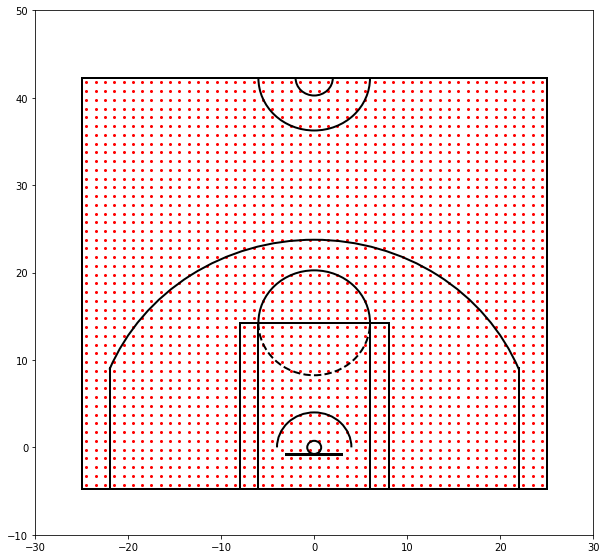

In [13]:
fig, ax = plt.subplots()
ax = draw_court(ax, outer_lines = True)
coords = bins_raw[0][0]
for i in range(ny):
    for j in range(nx):
        ax.scatter(coords[0][i,j],coords[1][i,j], color = 'r', s = 4)
ax.set_xlim([-30,30])
ax.set_ylim([-10,50])
ax.set_aspect(47/50)
fig.set_size_inches(10,10)

In [14]:
player_bin = bins_raw[player_name_map["Russell Westbrook"]]
covariates = ['pos', 'dist']

X_with_bias = np.ones((nx * ny,1))
if 'pos' in covariates:
    # Position based in X, Y coordinates
    positions = []
    for i in range(47):
        for j in range(50):
            positions.append(np.array([player_bin[0][0][i,j], player_bin[0][1][i,j]]))
    C = np.asarray(positions).reshape(-1, 2)
    X_with_bias = np.hstack([X_with_bias, C])

if 'dist' in covariates:
    # Strictly distance based
    dists = []
    for i in range(47):
        for j in range(50):
            dists.append(np.linalg.norm(np.array([player_bin[0][0][i,j],player_bin[0][1][i,j]])))
    C = np.array(dists).reshape(-1,1)
    X_with_bias = np.hstack([X_with_bias, C])
    
shots_total = player_bin[1]
shots_made = player_bin[2]
AM = player_bin[3]

data = {
    'N' : shots_total.flatten().shape[0],
    'p' : 1,
    'X' : np.array(dists).reshape(-1,1),
    'shots_total' : shots_total.flatten().astype(int),
    'shots_made' : shots_made.flatten().astype(int),
    'W' : AM,
    'W_n' : int(np.sum(AM)/2)
}

In [15]:
import pystan

### Independent distance dependent 

As a simple start, we can model shot probability strictly as function of a players $(x,y)$ positions and the euclidean distance from the hoop to add a little bit of non-linearity.  This would simply be a logistic regression.

$$
\begin{align}
\beta &\sim \operatorname{Normal(0, 1)} \\
\text{Made Shots}_{x,y} &\sim \operatorname{Binomial}(\text{Total Shots}_{x,y}, \sigma( X\beta ))
\end{align}
$$

Then, we can get a prediction for the probability of each shot by regression.

In [16]:
independent_bernoulli_model_code = """
data {
    int<lower = 1> N;
    int<lower = 1> p;
    matrix[N, p] X;
    int<lower = 0> shots_total[N];
    int<lower = 0> shots_made[N];
}

parameters {
    vector[p] beta;
}

model {
    beta ~ normal(0, 1);
    
    for(i in 1:N) {
        shots_made[i] ~ binomial(shots_total[i], inv_logit(X[i,] * beta));
    }
}
"""
independent_bernoulli_model = pystan.StanModel(model_code = independent_bernoulli_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_04f60e0823f7e03d46d17fe66293d175 NOW.


In [17]:
nonzero_idxs = np.where(total_shots.flatten() != 0)[0]
X_with_bias_nonzero = X_with_bias[nonzero_idxs,:]
shots_total_nonzero = shots_total.flatten().astype(int)[nonzero_idxs]
shots_made_nonzero = shots_made.flatten().astype(int)[nonzero_idxs]
data = {
    'N' : X_with_bias_nonzero.shape[0],
    'p' : X_with_bias_nonzero.shape[1],
    'X' : X_with_bias_nonzero,
    'shots_total' : shots_total_nonzero.flatten().astype(int),
    'shots_made' : shots_made_nonzero.flatten().astype(int)
}

In [18]:
fit = independent_bernoulli_model.sampling(data = data, iter = 1000)

In [19]:
beta = fit.extract()['beta']
probs = inv_logit(beta @ X_with_bias.T)
pt_values = get_shot_values(nx, ny)

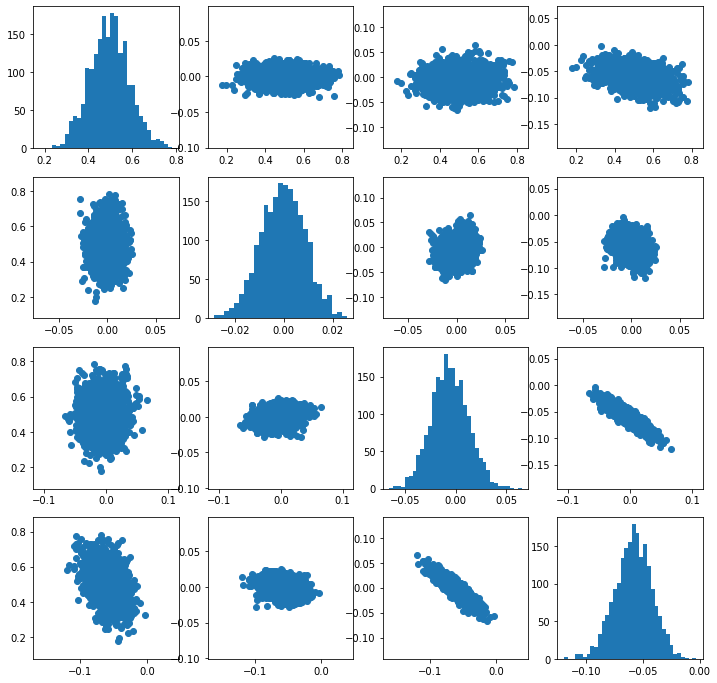

In [20]:
fig, ax = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        if i == j:
            ax[i,j].hist(beta[:,i], bins = 'auto')
        else:
            ax[i,j].scatter(beta[:,i], beta[:,j])
fig.set_size_inches(12,12)

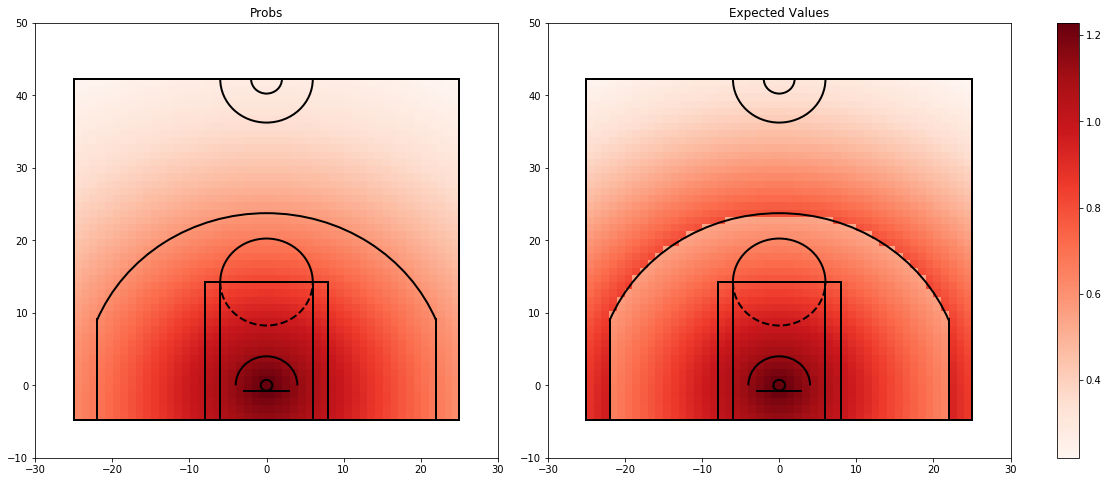

In [21]:
fig, ax = plt.subplots(1, 2)

ax[0] = draw_court(ax = ax[0], outer_lines = True)
ax[0].set_xlim([-30, 30])
ax[0].set_ylim([-10, 50])
ax[0].set_title("Probs")
p = ax[0].imshow(np.mean(probs, axis = 0).reshape(47,50), cmap = 'Reds', extent = ([-25,25,-4.75,-4.75 + 47]))
ax[0].set_aspect(47/50)

ax[1] = draw_court(ax = ax[1], outer_lines = True)
ax[1].set_xlim([-30, 30])
ax[1].set_ylim([-10, 50])
ax[1].set_title("Expected Values")
p = ax[1].imshow(np.mean(probs.reshape(-1,47,50)* pt_values, axis = 0), cmap = 'Reds', extent = ([-25,25,-4.75,-4.75 + 47]))
ax[1].set_aspect(47/50)


fig.subplots_adjust(wspace = -0.5)
fig.colorbar(p, ax = ax[1])
fig.set_size_inches(25,8)

In [ ]:
probs.reshape(-1,47,50) * pt_values

Looking at the results, it's a bit noisy - near point should also have similar probability.

## Spatial GMRF with Fixed Effect

In [ ]:
spatial_sparse_car_model_fere_code = """
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real tau, real alpha, 
    int[,] W_sparse, vector D_sparse, vector lambda, int n, int W_n) {
      row_vector[n] phit_D; // phi' * D
      row_vector[n] phit_W; // phi' * W
      vector[n] ldet_terms;
    
      phit_D = (phi .* D_sparse)';
      phit_W = rep_row_vector(0, n);
      for (i in 1:W_n) {
        phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
        phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
      }
    
      for (i in 1:n) ldet_terms[i] = log1m(alpha * lambda[i]);
      return 0.5 * (n * log(tau)
                    + sum(ldet_terms)
                    - tau * (phit_D * phi - alpha * (phit_W * phi)));
  }
}

data {
  
  int<lower = 1> N; // number of positions
  int<lower = 1> p; // number of covariates
  int<lower = 0> shots_total[N]; // Number of total shots
  int<lower = 0> shots_made[N]; // Number of shots made
  matrix[N,p] X; // covariate values for each location
  matrix<lower = 0, upper = 1>[N, N] W; // dense adjacency matrix
  int W_n;
  int<
}

transformed data {
  int W_sparse[W_n, 2];   // adjacency pairs
  vector[N] D_sparse;     // diagonal of D (number of neigbors for each site)
  vector[N] lambda;       // eigenvalues of invsqrtD * W * invsqrtD
  
  { // generate sparse representation for W
  int counter;
  counter = 1;
  // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1:(N - 1)) {
      for (j in (i + 1):N) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1:N) D_sparse[i] = sum(W[i]);
  {
    vector[N] invsqrtD;  
    for (i in 1:N) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}

parameters {
  vector[N] phi; // location specific random effect
  vector[p] beta;
  real<lower = 0> tau; // spatial precision parameter
  real<lower = 0, upper = 1> alpha; // intensity of spatial dependence
}

model {
  beta ~ normal(0,1);
  phi ~ sparse_car(tau, alpha, W_sparse, D_sparse, lambda, N, W_n);
  tau ~ gamma(2, 2);
  for(i in 1:N) {
      shots_made ~ binomial(shots_total, inv_logit(X[i,] * beta + phi[i]));
  }
}

"""
spatial_car_model_fere = pystan.StanModel(model_code = spatial_sparse_car_model_fere_code) 

In [ ]:
data = {
    'N' : X_with_bias_nonzero.shape[0],
    'p' : 2,
    'X' : X_with_bias_nonzero,
    'shots_total' : shots_total_nonzero.flatten().astype(int),
    'shots_made' : shots_made_nonzero.flatten().astype(int)
}

data = {
    'N' : X_with_bias_nonzero.shape[0],
    'p' : 2,
    'X' : X_with_bias_nonzero,
    'shots_total' : shots_total_nonzero.flatten().astype(int),
    'shots_made' : shots_made_nonzero.flatten().astype(int),
    'nonzero_idxs' : nonzero_idxs,
    'W' : AM,
    'W_n' : int(np.sum(AM)/2),
}

In [ ]:
fit = spatial_car_model_fere.sampling(data = data, iter = 1000, chains = 1)

In [ ]:
plt.hist(fit.extract()['beta'][:,0], bins = 'auto')

In [ ]:
phi = fit.extract()['phi']
beta = fit.extract()['beta']
probs_only_dist = inv_logit((beta * X.T))
probs_only_phi = inv_logit(phi)
probs = inv_logit((beta * X.T) + phi)

In [ ]:
np.max(X)

In [ ]:
fig, ax = plt.subplots()
p = ax.imshow(np.mean(probs, axis = 0).reshape(47,50).T, origin = 'lower')
ax.set_aspect(47/50)
fig.colorbar(p, ax = ax)
fig.set_size_inches(10,10)

In [ ]:
probs = probs.reshape(-1,nx,ny)
probs_only_dist = probs_only_dist.reshape(-1, nx, ny)
probs_only_phi = probs_only_phi.reshape(-1, nx, ny)

In [ ]:
fig, ax = plt.subplots()
sns.distplot(probs[:,3,0], bins = 'auto', ax = ax, label = 'FE + RE')
sns.distplot(probs_only_dist[:,3,0], bins = 'auto', ax = ax, label = 'FE')
sns.distplot(probs_only_phi[:,3,0], bins = 'auto', ax = ax, label = 'RE')
ax.legend()

In [ ]:
fig, ax = plt.subplots()

prob_vals = ax.imshow(probs[0,:,:].T, origin = 'lower', extent = [shot_x_range[0], shot_x_range[1], shot_y_range[0], shot_y_range[1]])
ax.set_xlim([-30.0, 30.0])
ax.set_ylim([-10.0, 50.0])
ax = draw_court(ax = ax, outer_lines = True)
def init():
    prob_vals.set_data(probs[0,:,:].T)
    return [prob_vals]

def animate(i):
    prob_vals.set_array(probs[i,:,:].T)
    return [prob_vals]

ani = animation.FuncAnimation(fig, animate, frames = len(probs[0,:]), blit = True, init_func = init)

In [ ]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=.75, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-3.0, -.75), 6.0, -.1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-8.0, -4.75), 16.0, 19.0, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-6.0, -4.75), 12.0, 19.0, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 14.25), 12.0, 12.0, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 14.25), 12.0, 12.0, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 8.0, 8.0, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-22.0, -4.75), 0, 14.0, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((22.0, -4.75), 0, 14.0, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 47.5, 47.5, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 42.25), 12.0, 12.0, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 42.25), 4.0, 4.0, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-25.0, -4.75), 50.0, 47.0, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [ ]:
plt.figure(figsize=(12,11))
ax = draw_court(outer_lines=True)
ilx = (shot_x_range[1] - shot_x_range[0])/nx
ily = (shot_y_range[1] - shot_y_range[0])/ny
for j in range(nx + 1):
    ax.axvline(ilx * j + shot_x_range[0])
    ax.axhline(ily * j + shot_y_range[0])
plt.xlim(-30.0,30.0)
plt.ylim(-10.0,50.0)
plt.show()

In [ ]:
HTML(ani.to_html5_video())

## Fitting a Spatial GP over shot data

In [ ]:
spatial_gp_stan_model_code = """
data {
  int<lower=1> N; // Number of data points
  vector[2] x[N]; // Coordinates of bins
  int shots_total[N]; // Number of total shots
  int shots_made[N]; // Number of shots made
}

parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  vector[N] eta;
}

transformed parameters {
 vector[N] f;
  {
    matrix[N, N] L_K;
    matrix[N, N] K = cov_exp_quad(x, alpha, rho);

    // diagonal elements
    for (n in 1:N)
      K[n, n] = K[n, n] + 1e-9;

    L_K = cholesky_decompose(K);
    f = L_K * eta;
  }
}

model {
  
  rho ~ inv_gamma(5, 5);
  alpha ~ std_normal();
  eta ~ std_normal();

  shots_made ~ binomial(shots_total, inv_logit(f));
}

"""
spatial_gp_stan_model = pystan.StanModel(model_code = spatial_gp_stan_model_code)

In [ ]:
data = {'N' : x.shape[0], 
        'x' : x,
        'shots_total' : y_total.astype(int),
        'shots_made'  : y_made.astype(int)}

In [ ]:
fit = spatial_gp_stan_model.sampling(data = data, iter = 1000, chains = 4)

In [ ]:
params = fit.extract(pars = ('rho', 'alpha'))

In [ ]:
sns.distplot(params['rho'], bins = 'auto')
sns.distplot(params['alpha'], bins  = 'auto')

In [ ]:
probs = 1/(1 + np.exp(-fit.extract(pars = ('f'))['f']))

In [ ]:
plt.imshow(probs[3,:].reshape(10,10))